## Notes 
### Required installing Oracle JAVA 8 to get javabridge installed
### Then, I was able to install py-causal from https://bd2kccd.github.io/docs/py-causal/
### GFCI is slower than RFCI, but more accurate (SPIRTES), GFCI and RFCI account for unobserved variables, FGES assumes no unobserved variables.

Structure Learning Performance Guarantees If the assumptions in the previous section hold, then in the large sample limit, the CBN structure output by GFCId will contain an edge of one of four kinds between Xand Y   if and only if Xand Yare not independent conditional on any subset of the other measured variables of less than or equal to a specified size. In addition, there is (1) an arc X->Y   if and only if Xdirectly or indirectly causes Y, and Y   does not directly or indirectly cause X; (2) an edge X <-->Y   if and only if X   is not a direct or indirect cause of Yand Y   is not a direct or indirect cause of X(which can only occur if there are latent confounders of Xand some other variable or Yand some other variable; (3) an edge Xo->Y   only if Yis not a direct or indirect cause of X, but Xmay or may not be an indirect cause of Y; (4) an edge X o–o Y   indicates that Xand Y   are dependent no matter what subset of observed variables is conditioned on, but contains no orientation information (X   may be a direct or indirect cause of Y, and Ymay be an indirect cause of X, or there may be a latent common cause of Xand Y.

# Trying some various ML models

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
from sklearn.metrics import roc_auc_score, average_precision_score, mean_squared_error, accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import pandas as pd
from pycausal import search as s
import configparser
import random
import numpy as np
import tensorflow as tf
from sklearn.metrics import roc_auc_score, average_precision_score
from keras.models import load_model
from keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.models import load_model, Model
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, BatchNormalization, \
                        Input, Dense, GlobalAveragePooling2D, Dropout
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.utils import to_categorical
from collections import Counter
import keras.optimizers
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.utils import plot_model
import glob, os
import tensorflow as tf
import pandas as pd
from random import shuffle

# select your GPU Here
os.environ["CUDA_VISIBLE_DEVICES"]="1" #Comment this line out if you want all GPUS (2 hehe)

# python full-display web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


def get_model(dense, dropouts, inputs, target_len):
    # dense is an ordered list of the number of dense neurons like [1024, 2048, 1024]
    # dropouts is an ordered list of the dropout masks like [0.2, 0.3, 0.4]
    inputs = keras.Input(shape = (inputs,))
    x = keras.layers.BatchNormalization()(inputs)
    x = keras.layers.Dense(dense[0], activation = 'relu')(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropouts[0])(x, training=True)
    for den, drop in zip(dense[1:], dropouts[1:]):
        x = keras.layers.Dense(den, activation = 'relu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Dropout(drop)(x, training=True)
    outputs = keras.layers.Dense(target_len, activation = 'linear')(x)
    model = keras.Model(inputs, outputs)
    return model


def discrete_gauss(low, high, samples, std = 20):
    x = np.arange(low, high)
    xU, xL = x + 0.5, x - 0.5 
    prob = ss.norm.cdf(xU, scale = std) - ss.norm.cdf(xL, scale = std)
    prob = prob / prob.sum() #normalize the probabilities so their sum is 1
    nums = np.random.choice(x, size = samples, p = prob)
    return nums



def bar_plot(x_ax, val1, val1std, val2, val2std):
    fig = plt.figure()
    ax = fig.add_subplot(111)

    ## the data
    N = len(x_ax)

    ## necessary variables
    ind = np.arange(N)                # the x locations for the groups
    width = 0.35                      # the width of the bars
    fig.set_size_inches(18.5, 10.5)
    ## the bars
    rects1 = ax.bar(ind, val1, width,
                    color='gray',
                    yerr=val1std,
                    error_kw=dict(elinewidth=2,ecolor='blue'))

    rects2 = ax.bar(ind+width, val2, width,
                        color='blue',
                        #yerr=val2std,
                        error_kw=dict(elinewidth=2,ecolor='gray'))

    # axes and labels
    ax.set_xlim(-width,len(ind)+width)
    #ax.set_ylim(0,45)
    ax.set_ylabel('Percentage')
    ax.set_title('')
    plt.xticks(ind + width / 2, x_ax, rotation=75, size = 14)
    ## add a legend
    ax.legend( (rects1[0], rects2[0]), ('Accuracy', '% Violations') )
    fig.savefig("violations.pdf", bbox_inches='tight')
    plt.show()

import pandas as pd
import numpy as np

def normalize(x):
    return x
    #return (x - x.min(0)) / x.ptp(0)

def gen_data(mean = 0, var = 1, SIZE = 2000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(mean, var, SIZE)
    estrogen =  2*bmi +  np.random.normal(mean,var, SIZE)
    age = np.random.normal(mean,var, SIZE)
    genes = 1.1 * age + estrogen +   np.random.normal(mean,var, SIZE)
    insomnia = estrogen +  np.random.normal(mean,var, SIZE)
    density = estrogen + genes + np.random.normal(mean,var, SIZE)
    cancer = density + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})


def get_CG(df, tetrad):
    tetrad.run(algoId = 'gfci', dfs = df, testId = 'sem-bic', scoreId = 'sem-bic', dataType = 'continuous',
           structurePrior = 1.0, samplePrior = 1.0, maxDegree = -1, maxPathLength = -1, 
           completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True)
    return tetrad.getTetradGraph()



from pycausal.pycausal import pycausal as pc
from collections import defaultdict
pc = pc()
pc.start_vm(java_max_heap_size = '5000M')
tetrad = s.tetradrunner()


verbosity = 1



models = []
model_names = []

num_models =100
model_layers = [1024,512]
for i in range(num_models):
    models.append(model_layers)
    model_names.append('temp/c' + str(i))

print(models, model_names)

from pycausal import prior as p
def get_bic(df, prior):

    tetrad.run(algoId = 'fges', dfs = df,  scoreId = 'sem-bic-deterministic', dataType = 'continuous',
               structurePrior = 1.0, samplePrior = 1, maxDegree = -1, maxPathLength = -1, priorKnowledge = prior,
               completeRuleSetUsed = False, faithfulnessAssumed = True, verbose = True,
               penaltyDiscount = 2
               )
    BIC = tetrad.getTetradGraph().getAllAttributes().toString()
    BIC = float(BIC.split('=')[-1].split('}')[0])
    return BIC #/ len(df)
import itertools
def get_pairs(lst):
    a = set()
    for i in itertools.permutations(lst,2):
        a.add(i)
    return a

inputs = ['bmi', 'density', 'age', 'genes', 'insomnia', 'estrogen']
target = ['cancer']
full_conx = get_pairs(inputs + target)
forced_conx = set({('age','genes'), ('bmi', 'estrogen'), ('estrogen', 'genes'),('estrogen', 'insomnia'), ('estrogen', 'density'), ('genes', 'density'), ('density', 'cancer')})
restricted_conx = full_conx.difference(forced_conx)   

prior = p.knowledge(requiredirect =  list(map(list, forced_conx)),
                       forbiddirect = list(map(list, restricted_conx))
                       )






df = gen_data(SIZE = 50000)

X = df[inputs].values
X = normalize(X)
y = df[target].values


val_df = gen_data(SIZE = 5000)

x_val = val_df[inputs].values
x_val = normalize(x_val)
y_val = val_df[target].values

get_bic(df,prior)

/home/tkyono/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d
/home/tkyono/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


[[1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512], [1024, 512]

-585281.2794720768

In [2]:
for idx, model_name in enumerate(model_names):
    print(model_name)

    if type(models[idx]) is list:
        #clear session
        keras.backend.clear_session() 
        #get model according to specification
        model = get_model(models[idx], [0.2] * len(models), len(inputs), 1)
        callbacks = [ModelCheckpoint(model_name, verbose= verbosity, monitor='val_loss',save_best_only=True), 
                     EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=2, verbose= verbosity, mode='auto')]
        model.compile(optimizer = optimizers.Adam(lr = 0.0001), loss='mse', metrics = ['mse'])
        #print(len(X), len(y))
        model.fit(X, y, epochs = 20, validation_data = (x_val, y_val), callbacks = callbacks, batch_size = 32, verbose = verbosity)
    else:
        models[idx].fit(X,y)


temp/c0
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 228us/step - loss: 2.9242 - mean_squared_error: 2.9242 - val_loss: 1.5282 - val_mean_squared_error: 1.5282

Epoch 00001: val_loss improved from inf to 1.52821, saving model to temp/c0
Epoch 2/20
50000/50000 [==============================] - 10s 201us/step - loss: 2.3936 - mean_squared_error: 2.3936 - val_loss: 1.6133 - val_mean_squared_error: 1.6133

Epoch 00002: val_loss did not improve from 1.52821
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.3018 - mean_squared_error: 2.3018 - val_loss: 1.3641 - val_mean_squared_error: 1.3641

Epoch 00003: val_loss improved from 1.52821 to 1.36405, saving model to temp/c0
Epoch 4/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.2282 - mean_squared_error: 2.2282 - val_loss: 1.3236 - val_mean_squared_error: 1.3236

Epoch 00004: val_loss improved from 1.36405 to 1.32360, 

50000/50000 [==============================] - 10s 203us/step - loss: 2.0846 - mean_squared_error: 2.0846 - val_loss: 1.4053 - val_mean_squared_error: 1.4053

Epoch 00007: val_loss did not improve from 1.24148
Epoch 00007: early stopping
temp/c4
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 217us/step - loss: 2.8993 - mean_squared_error: 2.8993 - val_loss: 1.6501 - val_mean_squared_error: 1.6501

Epoch 00001: val_loss improved from inf to 1.65009, saving model to temp/c4
Epoch 2/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.4708 - mean_squared_error: 2.4708 - val_loss: 1.4718 - val_mean_squared_error: 1.4718

Epoch 00002: val_loss improved from 1.65009 to 1.47183, saving model to temp/c4
Epoch 3/20
50000/50000 [==============================] - 10s 205us/step - loss: 2.3170 - mean_squared_error: 2.3170 - val_loss: 1.3377 - val_mean_squared_error: 1.3377

Epoch 00003: val_loss improved from 1.4

50000/50000 [==============================] - 10s 204us/step - loss: 2.0653 - mean_squared_error: 2.0653 - val_loss: 1.1728 - val_mean_squared_error: 1.1728

Epoch 00011: val_loss did not improve from 1.14811
Epoch 00011: early stopping
temp/c8
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 216us/step - loss: 2.8294 - mean_squared_error: 2.8294 - val_loss: 1.5927 - val_mean_squared_error: 1.5927

Epoch 00001: val_loss improved from inf to 1.59271, saving model to temp/c8
Epoch 2/20
50000/50000 [==============================] - 10s 205us/step - loss: 2.5244 - mean_squared_error: 2.5244 - val_loss: 1.4876 - val_mean_squared_error: 1.4876

Epoch 00002: val_loss improved from 1.59271 to 1.48761, saving model to temp/c8
Epoch 3/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.3551 - mean_squared_error: 2.3551 - val_loss: 1.3539 - val_mean_squared_error: 1.3539

Epoch 00003: val_loss improved from 1.4


Epoch 00002: val_loss did not improve from 1.67833
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.2912 - mean_squared_error: 2.2912 - val_loss: 1.3894 - val_mean_squared_error: 1.3894

Epoch 00003: val_loss improved from 1.67833 to 1.38942, saving model to temp/c12
Epoch 4/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.2819 - mean_squared_error: 2.2819 - val_loss: 1.3216 - val_mean_squared_error: 1.3216

Epoch 00004: val_loss improved from 1.38942 to 1.32161, saving model to temp/c12
Epoch 5/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.2132 - mean_squared_error: 2.2132 - val_loss: 1.2856 - val_mean_squared_error: 1.2856

Epoch 00005: val_loss improved from 1.32161 to 1.28564, saving model to temp/c12
Epoch 6/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.1355 - mean_squared_error: 2.1355 - val_loss: 1.1743 - val_mean_squared_error: 1.1743

Epoch 00006: val_loss imp

Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 214us/step - loss: 2.9336 - mean_squared_error: 2.9336 - val_loss: 1.7104 - val_mean_squared_error: 1.7104

Epoch 00001: val_loss improved from inf to 1.71040, saving model to temp/c16
Epoch 2/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.4586 - mean_squared_error: 2.4586 - val_loss: 1.4659 - val_mean_squared_error: 1.4659

Epoch 00002: val_loss improved from 1.71040 to 1.46587, saving model to temp/c16
Epoch 3/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.3755 - mean_squared_error: 2.3755 - val_loss: 1.4593 - val_mean_squared_error: 1.4593

Epoch 00003: val_loss improved from 1.46587 to 1.45933, saving model to temp/c16
Epoch 4/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.3284 - mean_squared_error: 2.3284 - val_loss: 1.2985 - val_mean_squared_error: 1.2985

Epoch 00004: val_loss improved f


Epoch 00003: val_loss did not improve from 1.44162
Epoch 4/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.2353 - mean_squared_error: 2.2353 - val_loss: 1.2824 - val_mean_squared_error: 1.2824

Epoch 00004: val_loss improved from 1.44162 to 1.28238, saving model to temp/c20
Epoch 5/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.2023 - mean_squared_error: 2.2023 - val_loss: 1.3802 - val_mean_squared_error: 1.3802

Epoch 00005: val_loss did not improve from 1.28238
Epoch 6/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1163 - mean_squared_error: 2.1163 - val_loss: 1.2822 - val_mean_squared_error: 1.2822

Epoch 00006: val_loss improved from 1.28238 to 1.28222, saving model to temp/c20
Epoch 7/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.0594 - mean_squared_error: 2.0594 - val_loss: 1.2646 - val_mean_squared_error: 1.2646

Epoch 00007: val_loss improved from 1.28222 to 1.26459,

50000/50000 [==============================] - 11s 216us/step - loss: 2.8497 - mean_squared_error: 2.8497 - val_loss: 1.6082 - val_mean_squared_error: 1.6082

Epoch 00001: val_loss improved from inf to 1.60819, saving model to temp/c23
Epoch 2/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.3901 - mean_squared_error: 2.3901 - val_loss: 1.3912 - val_mean_squared_error: 1.3912

Epoch 00002: val_loss improved from 1.60819 to 1.39119, saving model to temp/c23
Epoch 3/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.2967 - mean_squared_error: 2.2967 - val_loss: 1.4181 - val_mean_squared_error: 1.4181

Epoch 00003: val_loss did not improve from 1.39119
Epoch 4/20
50000/50000 [==============================] - 10s 205us/step - loss: 2.2713 - mean_squared_error: 2.2713 - val_loss: 1.5228 - val_mean_squared_error: 1.5228

Epoch 00004: val_loss did not improve from 1.39119
Epoch 00004: early stopping
temp/c24
Train on 50000 samples, validate o

Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 216us/step - loss: 2.8463 - mean_squared_error: 2.8463 - val_loss: 1.5175 - val_mean_squared_error: 1.5175

Epoch 00001: val_loss improved from inf to 1.51750, saving model to temp/c27
Epoch 2/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.4507 - mean_squared_error: 2.4507 - val_loss: 1.6533 - val_mean_squared_error: 1.6533

Epoch 00002: val_loss did not improve from 1.51750
Epoch 3/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.2679 - mean_squared_error: 2.2679 - val_loss: 1.8718 - val_mean_squared_error: 1.8718

Epoch 00003: val_loss did not improve from 1.51750
Epoch 00003: early stopping
temp/c28
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 217us/step - loss: 2.8534 - mean_squared_error: 2.8534 - val_loss: 1.6419 - val_mean_squared_error: 1.6419

Epoch 


Epoch 00002: val_loss improved from 1.63743 to 1.59404, saving model to temp/c32
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.3616 - mean_squared_error: 2.3616 - val_loss: 1.3594 - val_mean_squared_error: 1.3594

Epoch 00003: val_loss improved from 1.59404 to 1.35940, saving model to temp/c32
Epoch 4/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.1989 - mean_squared_error: 2.1989 - val_loss: 1.2748 - val_mean_squared_error: 1.2748

Epoch 00004: val_loss improved from 1.35940 to 1.27479, saving model to temp/c32
Epoch 5/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.2687 - mean_squared_error: 2.2687 - val_loss: 1.2523 - val_mean_squared_error: 1.2523

Epoch 00005: val_loss improved from 1.27479 to 1.25226, saving model to temp/c32
Epoch 6/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.2029 - mean_squared_error: 2.2029 - val_loss: 1.3079 - val_mean_squared_error: 1.3


Epoch 00002: val_loss did not improve from 1.56599
Epoch 3/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.3348 - mean_squared_error: 2.3348 - val_loss: 1.4963 - val_mean_squared_error: 1.4963

Epoch 00003: val_loss improved from 1.56599 to 1.49634, saving model to temp/c36
Epoch 4/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.2772 - mean_squared_error: 2.2772 - val_loss: 1.3574 - val_mean_squared_error: 1.3574

Epoch 00004: val_loss improved from 1.49634 to 1.35738, saving model to temp/c36
Epoch 5/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.2487 - mean_squared_error: 2.2487 - val_loss: 1.3418 - val_mean_squared_error: 1.3418

Epoch 00005: val_loss improved from 1.35738 to 1.34184, saving model to temp/c36
Epoch 6/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1701 - mean_squared_error: 2.1701 - val_loss: 1.4285 - val_mean_squared_error: 1.4285

Epoch 00006: val_loss did

50000/50000 [==============================] - 10s 203us/step - loss: 2.1089 - mean_squared_error: 2.1089 - val_loss: 1.2143 - val_mean_squared_error: 1.2143

Epoch 00008: val_loss did not improve from 1.19176
Epoch 9/20
50000/50000 [==============================] - 10s 201us/step - loss: 2.0916 - mean_squared_error: 2.0916 - val_loss: 1.2229 - val_mean_squared_error: 1.2229

Epoch 00009: val_loss did not improve from 1.19176
Epoch 00009: early stopping
temp/c40
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 216us/step - loss: 2.8748 - mean_squared_error: 2.8748 - val_loss: 2.0580 - val_mean_squared_error: 2.0580

Epoch 00001: val_loss improved from inf to 2.05795, saving model to temp/c40
Epoch 2/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.5035 - mean_squared_error: 2.5035 - val_loss: 1.6523 - val_mean_squared_error: 1.6523

Epoch 00002: val_loss improved from 2.05795 to 1.65228, saving mod


Epoch 00003: val_loss did not improve from 1.40623
Epoch 4/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.2511 - mean_squared_error: 2.2511 - val_loss: 1.4566 - val_mean_squared_error: 1.4566

Epoch 00004: val_loss did not improve from 1.40623
Epoch 00004: early stopping
temp/c45
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 218us/step - loss: 2.8294 - mean_squared_error: 2.8294 - val_loss: 1.5539 - val_mean_squared_error: 1.5539

Epoch 00001: val_loss improved from inf to 1.55392, saving model to temp/c45
Epoch 2/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.4675 - mean_squared_error: 2.4675 - val_loss: 1.5313 - val_mean_squared_error: 1.5313

Epoch 00002: val_loss improved from 1.55392 to 1.53126, saving model to temp/c45
Epoch 3/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.3137 - mean_squared_error: 2.3137 - val_loss: 1.4490 - val_m


Epoch 00011: val_loss did not improve from 1.11290
Epoch 12/20
50000/50000 [==============================] - 10s 202us/step - loss: 1.9857 - mean_squared_error: 1.9857 - val_loss: 1.4113 - val_mean_squared_error: 1.4113

Epoch 00012: val_loss did not improve from 1.11290
Epoch 00012: early stopping
temp/c49
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 11s 216us/step - loss: 2.7796 - mean_squared_error: 2.7796 - val_loss: 1.6120 - val_mean_squared_error: 1.6120

Epoch 00001: val_loss improved from inf to 1.61201, saving model to temp/c49
Epoch 2/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.4248 - mean_squared_error: 2.4248 - val_loss: 1.3892 - val_mean_squared_error: 1.3892

Epoch 00002: val_loss improved from 1.61201 to 1.38920, saving model to temp/c49
Epoch 3/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.3573 - mean_squared_error: 2.3573 - val_loss: 1.4553 - val_

50000/50000 [==============================] - 10s 205us/step - loss: 2.1438 - mean_squared_error: 2.1438 - val_loss: 1.3903 - val_mean_squared_error: 1.3903

Epoch 00005: val_loss improved from 1.39060 to 1.39034, saving model to temp/c53
Epoch 6/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1742 - mean_squared_error: 2.1742 - val_loss: 1.4392 - val_mean_squared_error: 1.4392

Epoch 00006: val_loss did not improve from 1.39034
Epoch 7/20
50000/50000 [==============================] - 10s 206us/step - loss: 2.1122 - mean_squared_error: 2.1122 - val_loss: 1.3797 - val_mean_squared_error: 1.3797

Epoch 00007: val_loss improved from 1.39034 to 1.37974, saving model to temp/c53
Epoch 8/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.0868 - mean_squared_error: 2.0868 - val_loss: 1.1731 - val_mean_squared_error: 1.1731

Epoch 00008: val_loss improved from 1.37974 to 1.17312, saving model to temp/c53
Epoch 9/20
50000/50000 [=============

50000/50000 [==============================] - 10s 203us/step - loss: 2.2256 - mean_squared_error: 2.2256 - val_loss: 1.2276 - val_mean_squared_error: 1.2276

Epoch 00005: val_loss improved from 1.41788 to 1.22756, saving model to temp/c57
Epoch 6/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1568 - mean_squared_error: 2.1568 - val_loss: 1.2060 - val_mean_squared_error: 1.2060

Epoch 00006: val_loss improved from 1.22756 to 1.20604, saving model to temp/c57
Epoch 7/20
50000/50000 [==============================] - 10s 201us/step - loss: 2.1189 - mean_squared_error: 2.1189 - val_loss: 1.2870 - val_mean_squared_error: 1.2870

Epoch 00007: val_loss did not improve from 1.20604
Epoch 8/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.0981 - mean_squared_error: 2.0981 - val_loss: 1.2559 - val_mean_squared_error: 1.2559

Epoch 00008: val_loss did not improve from 1.20604
Epoch 00008: early stopping
temp/c58
Train on 50000 samples, valida

50000/50000 [==============================] - 10s 203us/step - loss: 2.1354 - mean_squared_error: 2.1354 - val_loss: 1.4135 - val_mean_squared_error: 1.4135

Epoch 00006: val_loss did not improve from 1.32101
Epoch 7/20
50000/50000 [==============================] - 10s 204us/step - loss: 2.1246 - mean_squared_error: 2.1246 - val_loss: 1.2645 - val_mean_squared_error: 1.2645

Epoch 00007: val_loss improved from 1.32101 to 1.26455, saving model to temp/c61
Epoch 8/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.0774 - mean_squared_error: 2.0774 - val_loss: 1.1771 - val_mean_squared_error: 1.1771

Epoch 00008: val_loss improved from 1.26455 to 1.17710, saving model to temp/c61
Epoch 9/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.1023 - mean_squared_error: 2.1023 - val_loss: 1.3533 - val_mean_squared_error: 1.3533

Epoch 00009: val_loss did not improve from 1.17710
Epoch 10/20
50000/50000 [==============================] - 10s 201u

50000/50000 [==============================] - 10s 203us/step - loss: 2.0468 - mean_squared_error: 2.0468 - val_loss: 1.2205 - val_mean_squared_error: 1.2205

Epoch 00008: val_loss improved from 1.22939 to 1.22049, saving model to temp/c64
Epoch 9/20
50000/50000 [==============================] - 10s 202us/step - loss: 2.0433 - mean_squared_error: 2.0433 - val_loss: 1.1327 - val_mean_squared_error: 1.1327

Epoch 00009: val_loss improved from 1.22049 to 1.13273, saving model to temp/c64
Epoch 10/20
50000/50000 [==============================] - 10s 203us/step - loss: 2.0650 - mean_squared_error: 2.0650 - val_loss: 1.1509 - val_mean_squared_error: 1.1509

Epoch 00010: val_loss did not improve from 1.13273
Epoch 11/20
50000/50000 [==============================] - 10s 203us/step - loss: 1.9930 - mean_squared_error: 1.9930 - val_loss: 1.1593 - val_mean_squared_error: 1.1593

Epoch 00011: val_loss did not improve from 1.13273
Epoch 00011: early stopping
temp/c65
Train on 50000 samples, vali

50000/50000 [==============================] - 10s 208us/step - loss: 2.3455 - mean_squared_error: 2.3455 - val_loss: 1.3674 - val_mean_squared_error: 1.3674

Epoch 00003: val_loss improved from 1.50658 to 1.36736, saving model to temp/c68
Epoch 4/20
50000/50000 [==============================] - 10s 206us/step - loss: 2.2327 - mean_squared_error: 2.2327 - val_loss: 1.3979 - val_mean_squared_error: 1.3979

Epoch 00004: val_loss did not improve from 1.36736
Epoch 5/20
50000/50000 [==============================] - 10s 208us/step - loss: 2.1809 - mean_squared_error: 2.1809 - val_loss: 1.2480 - val_mean_squared_error: 1.2480

Epoch 00005: val_loss improved from 1.36736 to 1.24796, saving model to temp/c68
Epoch 6/20
50000/50000 [==============================] - 10s 207us/step - loss: 2.1464 - mean_squared_error: 2.1464 - val_loss: 1.1986 - val_mean_squared_error: 1.1986

Epoch 00006: val_loss improved from 1.24796 to 1.19862, saving model to temp/c68
Epoch 7/20
50000/50000 [=============

50000/50000 [==============================] - 12s 247us/step - loss: 2.1471 - mean_squared_error: 2.1471 - val_loss: 1.4880 - val_mean_squared_error: 1.4880

Epoch 00006: val_loss did not improve from 1.36284
Epoch 00006: early stopping
temp/c72
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 260us/step - loss: 2.8410 - mean_squared_error: 2.8410 - val_loss: 1.5603 - val_mean_squared_error: 1.5603

Epoch 00001: val_loss improved from inf to 1.56031, saving model to temp/c72
Epoch 2/20
50000/50000 [==============================] - 12s 249us/step - loss: 2.4245 - mean_squared_error: 2.4245 - val_loss: 1.5018 - val_mean_squared_error: 1.5018

Epoch 00002: val_loss improved from 1.56031 to 1.50179, saving model to temp/c72
Epoch 3/20
50000/50000 [==============================] - 12s 246us/step - loss: 2.3130 - mean_squared_error: 2.3130 - val_loss: 1.5650 - val_mean_squared_error: 1.5650

Epoch 00003: val_loss did not improv


Epoch 00004: val_loss improved from 1.43463 to 1.34004, saving model to temp/c76
Epoch 5/20
50000/50000 [==============================] - 12s 246us/step - loss: 2.2240 - mean_squared_error: 2.2240 - val_loss: 1.5855 - val_mean_squared_error: 1.5855

Epoch 00005: val_loss did not improve from 1.34004
Epoch 6/20
50000/50000 [==============================] - 12s 248us/step - loss: 2.1730 - mean_squared_error: 2.1730 - val_loss: 1.4074 - val_mean_squared_error: 1.4074

Epoch 00006: val_loss did not improve from 1.34004
Epoch 00006: early stopping
temp/c77
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 258us/step - loss: 2.9026 - mean_squared_error: 2.9026 - val_loss: 1.5466 - val_mean_squared_error: 1.5466

Epoch 00001: val_loss improved from inf to 1.54664, saving model to temp/c77
Epoch 2/20
50000/50000 [==============================] - 12s 249us/step - loss: 2.4747 - mean_squared_error: 2.4747 - val_loss: 1.6217 - val_m

50000/50000 [==============================] - 12s 249us/step - loss: 2.5162 - mean_squared_error: 2.5162 - val_loss: 1.5561 - val_mean_squared_error: 1.5561

Epoch 00002: val_loss did not improve from 1.54358
Epoch 3/20
50000/50000 [==============================] - 12s 249us/step - loss: 2.3362 - mean_squared_error: 2.3362 - val_loss: 1.3299 - val_mean_squared_error: 1.3299

Epoch 00003: val_loss improved from 1.54358 to 1.32989, saving model to temp/c81
Epoch 4/20
50000/50000 [==============================] - 12s 246us/step - loss: 2.2826 - mean_squared_error: 2.2826 - val_loss: 1.3084 - val_mean_squared_error: 1.3084

Epoch 00004: val_loss improved from 1.32989 to 1.30837, saving model to temp/c81
Epoch 5/20
50000/50000 [==============================] - 12s 248us/step - loss: 2.1953 - mean_squared_error: 2.1953 - val_loss: 1.3065 - val_mean_squared_error: 1.3065

Epoch 00005: val_loss improved from 1.30837 to 1.30653, saving model to temp/c81
Epoch 6/20
50000/50000 [=============

50000/50000 [==============================] - 12s 247us/step - loss: 2.2986 - mean_squared_error: 2.2986 - val_loss: 1.2486 - val_mean_squared_error: 1.2486

Epoch 00004: val_loss improved from 1.33597 to 1.24864, saving model to temp/c84
Epoch 5/20
50000/50000 [==============================] - 12s 248us/step - loss: 2.2017 - mean_squared_error: 2.2017 - val_loss: 1.2599 - val_mean_squared_error: 1.2599

Epoch 00005: val_loss did not improve from 1.24864
Epoch 6/20
50000/50000 [==============================] - 12s 247us/step - loss: 2.1396 - mean_squared_error: 2.1396 - val_loss: 1.5571 - val_mean_squared_error: 1.5571

Epoch 00006: val_loss did not improve from 1.24864
Epoch 00006: early stopping
temp/c85
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 261us/step - loss: 2.9164 - mean_squared_error: 2.9164 - val_loss: 1.7073 - val_mean_squared_error: 1.7073

Epoch 00001: val_loss improved from inf to 1.70727, saving mod


Epoch 00007: val_loss did not improve from 1.18175
Epoch 8/20
50000/50000 [==============================] - 12s 247us/step - loss: 2.0998 - mean_squared_error: 2.0998 - val_loss: 1.2996 - val_mean_squared_error: 1.2996

Epoch 00008: val_loss did not improve from 1.18175
Epoch 00008: early stopping
temp/c90
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 260us/step - loss: 2.8341 - mean_squared_error: 2.8341 - val_loss: 1.5348 - val_mean_squared_error: 1.5348

Epoch 00001: val_loss improved from inf to 1.53481, saving model to temp/c90
Epoch 2/20
50000/50000 [==============================] - 12s 242us/step - loss: 2.3968 - mean_squared_error: 2.3968 - val_loss: 1.4463 - val_mean_squared_error: 1.4463

Epoch 00002: val_loss improved from 1.53481 to 1.44635, saving model to temp/c90
Epoch 3/20
50000/50000 [==============================] - 12s 247us/step - loss: 2.3110 - mean_squared_error: 2.3110 - val_loss: 1.3357 - val_m


Epoch 00013: val_loss did not improve from 1.07612
Epoch 00013: early stopping
temp/c94
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 259us/step - loss: 2.8859 - mean_squared_error: 2.8859 - val_loss: 1.5457 - val_mean_squared_error: 1.5457

Epoch 00001: val_loss improved from inf to 1.54574, saving model to temp/c94
Epoch 2/20
50000/50000 [==============================] - 12s 247us/step - loss: 2.4064 - mean_squared_error: 2.4064 - val_loss: 1.5484 - val_mean_squared_error: 1.5484

Epoch 00002: val_loss did not improve from 1.54574
Epoch 3/20
50000/50000 [==============================] - 12s 245us/step - loss: 2.3404 - mean_squared_error: 2.3404 - val_loss: 1.3669 - val_mean_squared_error: 1.3669

Epoch 00003: val_loss improved from 1.54574 to 1.36690, saving model to temp/c94
Epoch 4/20
50000/50000 [==============================] - 12s 246us/step - loss: 2.2380 - mean_squared_error: 2.2380 - val_loss: 1.5571 - val_m


Epoch 00004: val_loss improved from 1.32448 to 1.24891, saving model to temp/c98
Epoch 5/20
50000/50000 [==============================] - 12s 247us/step - loss: 2.2283 - mean_squared_error: 2.2283 - val_loss: 1.2423 - val_mean_squared_error: 1.2423

Epoch 00005: val_loss improved from 1.24891 to 1.24234, saving model to temp/c98
Epoch 6/20
50000/50000 [==============================] - 12s 248us/step - loss: 2.1413 - mean_squared_error: 2.1413 - val_loss: 1.3656 - val_mean_squared_error: 1.3656

Epoch 00006: val_loss did not improve from 1.24234
Epoch 7/20
50000/50000 [==============================] - 12s 247us/step - loss: 2.1246 - mean_squared_error: 2.1246 - val_loss: 1.3343 - val_mean_squared_error: 1.3343

Epoch 00007: val_loss did not improve from 1.24234
Epoch 00007: early stopping
temp/c99
Train on 50000 samples, validate on 5000 samples
Epoch 1/20
50000/50000 [==============================] - 13s 262us/step - loss: 2.8584 - mean_squared_error: 2.8584 - val_loss: 2.0605 - v

In [3]:
def gen_data(mean = 0.1, var = 1.2, SIZE = 2000):
    # set bmi to these values real world mean and standard deviation for a certain country.
    bmi = np.random.normal(mean, var, SIZE)
    estrogen =  2*bmi +  np.random.normal(mean,var, SIZE)
    age = np.random.normal(mean,var, SIZE)
    genes = 1.1 * age + estrogen +  np.random.normal(mean,var, SIZE)
    insomnia = estrogen +  np.random.normal(mean,var, SIZE)
    density = estrogen + genes + np.random.normal(mean,var, SIZE)
    cancer = density + np.random.normal(mean,var, SIZE)
    return pd.DataFrame({'bmi' : bmi,'density' : density, 'age' : age, 'cancer' : cancer, 'estrogen': estrogen, 'genes':genes, 'insomnia': insomnia})

from sklearn.metrics import mean_absolute_error
nb_test = 6000
metrics_dicts = []

perturbed_df = gen_data()
y_test2 = perturbed_df[target]
x_test2 = normalize(perturbed_df[inputs].values)
for idx, model_name in enumerate(model_names):

    if type(models[idx]) is list:
        keras.backend.clear_session()
        model = load_model(model_name)
    else:
        model = models[idx]
    #y_pred2 = model.predict(x_test2)[:,1]
    y_pred2 = model.predict(x_test2)
    print(mean_absolute_error(y_test2, y_pred2))
    metrics_dicts.append(mean_absolute_error(y_test2, y_pred2))



1.1045444005545215
0.9891069723311482
1.0945540088202792
1.0609516205368303
1.0581161922581865
1.102875837830242
1.0487987287915532
1.003691142858016
1.065068927325321
1.046184404815653
1.0154391881418752
1.022903504873902
1.0007123527348485
1.0737535204524633
1.005022967988206
1.0344379600075813
1.0436955367725762
0.9958771196747628
1.0590358732695146
1.0388864145562966
1.0738344323618803
1.0009646347530086
1.0107601086413593
1.1041318206345057
1.0400415839922448
1.0403867635719861
0.9838801531341833
1.1850067738100807
1.046271735933317
1.0796876767954109
1.0163212513072974
1.0641597471411393
1.014441191400064
1.0070149650795865
1.0703393305560582
1.0345782205347287
0.9870115959412039
1.0983869641335604
1.002648901448822
1.0227589441755929
1.030958560570318
1.078658404963646
1.1187298640758307
1.0706627059387719
1.0861730908257554
1.0115916293178646
1.031214315249626
1.076786243442735
0.9962832669880929
1.0860991505512498
1.085054338655672
1.062441610834301
0.9958708596740498
1.023249

In [4]:
np.min(perturbed_df['cancer']), np.min(df['cancer'])


(-18.778410976678792, -25.404208526529104)

In [7]:
#the number of times to sample
times = 4
## the size of the test set


violations = np.zeros(len(models))
violation_mean = np.zeros((len(models), times))
violation_mean2 = np.zeros((len(models), times))
mean = np.zeros((len(models), times))

fold = 0



for t in range(times):
    print("Times = ", t)
    df_test = gen_data(SIZE = nb_test)
    x_test = df_test[inputs].values
    x_test_norm = normalize(df_test[inputs].values)
    y_test = df_test[target].values
    #bic_orig = get_bic(df_test,prior)

    for idx, model_name in enumerate(model_names):
        if type(models[idx]) is list:
            keras.backend.clear_session()
            model = load_model(model_name)
        else:
            model = models[idx]
            
        predicted = model.predict(x_test_norm)
        test_df = pd.DataFrame(x_test, columns = inputs)
        test_targets = pd.DataFrame(predicted,columns = target)
        test_df = test_df.join(test_targets)
       
        
    
        mean[idx][t] = mean_squared_error(y_test, predicted) 
        test_df[test_df['cancer'] > 0.5] = 1
        test_df[test_df['cancer'] <= 0.5] = 0
        bic_pred = get_bic(test_df,prior)
        
        #bic_pred = get_bic(df_test.join(pd.DataFrame(model.predict(x_test), columns = ['target'])), prior)
        
        print(tetrad.getEdges())
        print(bic_pred)
        violation_mean[idx][t] = bic_pred
        violation_mean2[idx][t] = bic_pred
        #print(bic_orig - bic_pred)
metric = []
metric_err = []
viol = []
viol_err = []

#normalize the violations for prettier graphing.
#also violations are always positive, so just divide by max.

#TMK
#violation_mean = violation_mean / np.max(violation_mean)

for i in range(len(violations)):
    print("Model_name = ", model_names[i], "Violations = ", violations[i])
    print("Average_violations = ", np.mean(violation_mean[i]), np.std(violation_mean[i]))
    print("MSE = ", np.mean(mean[i]), np.std(mean[i]))
    #print("mean = ", mean[i])
    metric.append(np.mean(mean[i]))
    metric_err.append(np.std(mean[i]))
    viol.append(np.mean(violation_mean[i]))
    #viol.append(violations[i]/times)
    viol_err.append(np.std(violation_mean[i]))
   
    
MSE = []
VIO = []
VIO2 = []
AUS = []
for i, m in enumerate(models):
    MSE.append(np.mean(mean[i]))
    VIO.append(np.mean(violation_mean[i]))
    VIO2.append(np.mean(violation_mean2[i]))
    AUS.append(metrics_dicts[i])


Times =  0
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58219.74141897515
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58183.249501656755
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58284.53182140237
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58152.07403603442
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58121.13182128183
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58207.835955281385
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58175.73049285343
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58219.74141897515
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58222.81192869747
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58139.50101187643
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58275.22774807701
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58191.106620590246
Times =  1
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58294.072394354866
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58232.2495345104
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58365.23322488264
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58240.37337861698
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58267.954663736244
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58250.433202817694
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58227.48833436647
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58297.95487929776
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cance

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58180.7056067197
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58297.95487929777
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58332.48633254259
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58305.83348800239
Times =  2
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58191.106620590275
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density 

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58172.09772278097
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58188.45000161968
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58158.41103317237
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58150.036679605044
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58172.09772278098
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58206.3901205294
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58147.05091604744
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58114.09546246639
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58174.51018369333
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58262.599067286574
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer'

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58142.26198897944
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58163.94967869812
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58169.72279972743
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58185.830964317036
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58173.299260608524
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cance

['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58160.5983603384
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58135.08662863413
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58229.06597806234
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58152.07403603446
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']
58124.70414666929
['estrogen --> genes', 'age --> genes', 'genes --> density', 'estrogen --> insomnia', 'estrogen --> density', 'bmi --> estrogen', 'density --> cancer']

Best by BIC =  1.0622991004227884
Best by AUC =  0.9953133889158303
Best by MET =  1.017923793069502
Random =  1.0573892236121751
-0.08568540229987733


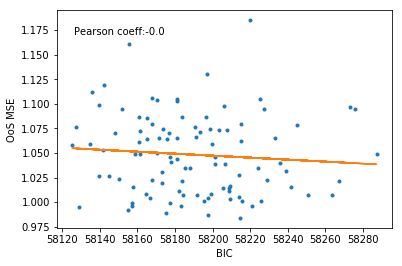

0.4607467154439681


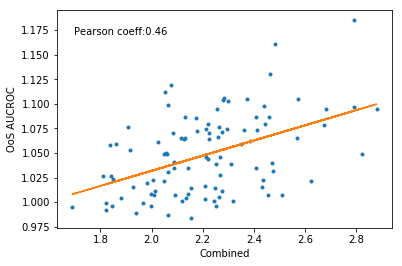

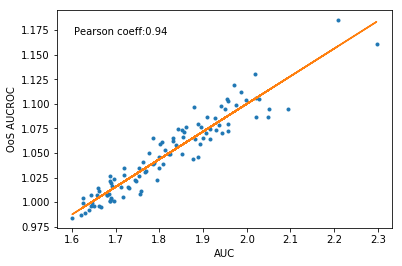

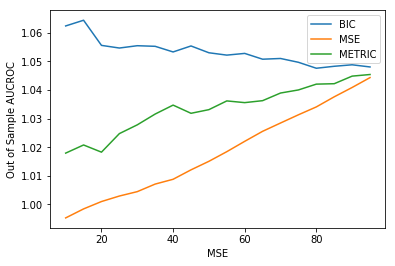

0.4607467154439681

In [8]:
from numpy.polynomial.polynomial import polyfit  
from scipy.stats import pearsonr
from pylab import text

def norm(a):
    return (a - np.min(a)) / a.ptp()
METRIC = norm(np.array(VIO)) + np.array(MSE)
n_low = 10
sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
print("Best by BIC = ", np.mean(sorted_aus[:n_low]))

sorted_aus = [AUS for _,AUS in sorted(zip(MSE,AUS))]
print("Best by AUC = ", np.mean(sorted_aus[:n_low]))


sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
print("Best by MET = ", np.mean(sorted_aus[:n_low]))
print("Random = ", np.mean(AUS[:n_low]))
print(pearsonr(VIO,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(VIO,AUS, 1)
ax.plot(VIO,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(VIO,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(VIO, b + m * np.array(VIO), '-')
ax.set_xlabel("BIC")
ax.set_ylabel("OoS MSE")
fig.savefig('Ex4VIOVsAUS.pdf', bbox_inches='tight')
plt.show()



print(pearsonr(METRIC,AUS)[0])
fig, ax = plt.subplots()
b,m = polyfit(METRIC,AUS, 1)
ax.plot(METRIC,AUS, '.')
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(METRIC,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
plt.plot(METRIC, b + m * np.array(METRIC), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("Combined")
ax.set_ylabel("OoS AUCROC")
fig.savefig('Ex4ProposedVsAUS.pdf', bbox_inches='tight')
plt.show()


fig, ax = plt.subplots()
b,m = polyfit(MSE,AUS, 1)
text(0.05, 0.9,'Pearson coeff:' + str(pearsonr(MSE,AUS)[0])[0:4], ha='left', va='center', transform=ax.transAxes)
ax.plot(MSE,AUS, '.')
plt.plot(MSE, b + m * np.array(MSE), '-')
    #cax = ax.scatter(VIO,AUS)
ax.set_xlabel("AUC")
ax.set_ylabel("OoS AUCROC")
fig.savefig('Ex4MSEVsAUS.pdf', bbox_inches='tight')
plt.show()


MSE = np.array(MSE)

x = []
y1 = []
y2 = []
y3 = []
for split in range(10, len(AUS), 5):
    #print("******", split, "*******")
    sorted_aus = [AUS for _,AUS in sorted(zip(VIO,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(VIO,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]

    x.append(split)
    
    
    #print("Low Violations = ", np.mean(low), "for", len(low))
    #print("High Violations = ", np.mean(high), "for", len(high))
    y1.append(np.mean(low)) 
    sorted_aus_by_mse = [AUS for _,AUS in sorted(zip(MSE,AUS))]
    low = sorted_aus_by_mse[:split]
    high = sorted_aus_by_mse[split:]
    #print("Low AUS by MSE = ", np.mean(low), "for", len(low))
    #print("High AUS by MSE = ", np.mean(high), "for", len(high))
    y2.append(np.mean(low))
    sorted_aus = [AUS for _,AUS in sorted(zip(METRIC,AUS))]
    sorted_mse = [MSE for _,MSE in sorted(zip(METRIC,MSE))]

    low = []
    high = []
    low = sorted_aus[:split]
    high = sorted_aus[split:]



    #print("Low Metric = ", np.mean(low), "for", len(low))
    #print("High Metric = ", np.mean(high), "for", len(high))
    y3.append(np.mean(low))
    

fig, ax = plt.subplots()

ax.plot(x,y1, '-', label = 'BIC')
ax.plot(x,y2, '-', label = 'MSE')
ax.plot(x,y3, '-', label = 'METRIC')
ax.legend()

ax.set_xlabel("MSE")
ax.set_ylabel("Out of Sample AUCROC")
plt.show()  
pearsonr(METRIC,AUS)[0]